<a href="https://colab.research.google.com/github/enerdb/Data-Camp-Courses/blob/main/Lockdown_cbmdf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de variação de ocorrências do CBMDF nos períodos de Lockdown

# Imports and Setup

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
from google.colab import drive

import matplotlib.pyplot as plt
import seaborn as sns
import warnings


warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [15, 10]


# DATA EXTRACTION Functions

### Extract Ocorrências

In [2]:
def carrega_dados_ocorrencias():
    drive.mount('/content/drive')
    dados = '/content/drive/MyDrive/Colab Notebooks/lockdown_cbmdf/analise_lockdownxls.xlsx'
    return pd.read_excel(dados)

### Extract Períodos de Lockdown

In [3]:
def carrega_dados_lockdown():
    lockdown_dict = {
          'DSC': 'Lockdown Total-Escolas Publicas-Escolas Particulares-Faculdades-Academias-Shoppings-Bares/Restaurantes-Salão de Beleza-Eventos locais abertos-Eventos locais fechados-Uso de Máscaras-Festas e Carnaval'.split('-'),
          'DATA_i': '10/03/2020-10/03/2020-10/03/2020-10/03/2020-10/03/2020-11/03/2020-10/03/2020-10/03/2020-10/03/2020-10/03/2020-10/03/2020-10/03/2020'.split('-'),
          'DATA_f': '13/03/2020-21/09/2021-05/03/2021-05/03/2021-05/03/2021-19/03/2021-19/03/2021-19/03/2021-03/03/2022-03/03/2022-10/03/2022-31/07/2022'.split('-')
                    }
    lockdown_df = pd.DataFrame(data=lockdown_dict)

    lockdown_df['DATA_i'] = pd.to_datetime(lockdown_df['DATA_i'], format = '%d/%m/%Y')
    lockdown_df['DATA_f'] = pd.to_datetime(lockdown_df['DATA_f'], format = '%d/%m/%Y')
    lockdown_df = lockdown_df.set_index('DSC')

    return lockdown_df

### Preparation Ocorrências

In [4]:
def prepara_ocorrencias(df):

    # Campo DATA
    df['DATAstr'] = df['ANO'].apply(int).apply(str) + ' ' + df['MES'].apply(int).apply(str)
    df['DATA'] = pd.to_datetime(df['DATAstr'], format = "%Y %m")
    df_clean1 = df.drop(columns = ['ANO', 'MES', 'DATAstr'])

    # Nampo NATUREZA
    df_clean1['NATUREZA'] = df_clean1['Dsc Grupo Fenix'] + ' - ' + df_clean1['Dsc Sub Grupo Fenix'] + ' - ' + df_clean1['Dsc Natureza Fenix']
    df_clean2 = df_clean1.drop(columns = ['Dsc Grupo Fenix', 'Dsc Sub Grupo Fenix', 'Dsc Natureza Fenix'])

    # Renomeando
    df_clean2.rename(columns = {'DSC CIDADE': 'CIDADE', 'COD TELEATENDIMENTO': 'QTE'}, inplace = True)

    return df_clean2


In [5]:
def agrega_ocorrencias_data(df):
    return df.groupby('DATA').sum()['QTE']

### Top 30 CIDADES e NATUREZAS

In [6]:
def gera_lista_top_campo(df, campo, n = 30):
    df_por_campo = df.groupby(campo)['QTE'] \
                                    .sum() \
                                    .reset_index(name = 'QTE') \
                                    .sort_values('QTE', ascending = False) \
                                    .head(n)
    return list(df_por_campo[campo])
              
                                    

### Definição de períodos de Lockdown

In [7]:
def ld_agg():
    lockdown_dict = {
          'DSC': 'Restrições Severas-Restrições Moderadas'.split('-'),
          'DATA_i': '10/03/2020-10/03/2020'.split('-'),
          'DATA_f': '01/03/2021-01/03/2022'.split('-')
                    }
    lockdown_df = pd.DataFrame(data=lockdown_dict)

    lockdown_df['DATA_i'] = pd.to_datetime(lockdown_df['DATA_i'], format = '%d/%m/%Y')
    lockdown_df['DATA_f'] = pd.to_datetime(lockdown_df['DATA_f'], format = '%d/%m/%Y')
    lockdown_df = lockdown_df.set_index('DSC')

    return lockdown_df

### Filtra dados

In [8]:
def filtra_cidade(df, cidade):
    return df[df['CIDADE']==cidade]

def filtra_natureza(df, natureza):
    return df[df['NATUREZA']==natureza]

# Filtra datas por período de lockdown
def filtra_periodo(df, lockdown_df, restricao):
    datai = lockdown_df.loc[restricao]['DATA_i']
    dataf = lockdown_df.loc[restricao]['DATA_f']
    c0 = df.index.to_series().between(datai, dataf)
    return df[c0]

# Statistical Test Functions

In [19]:
def testa_normal(df, nome = 'Esta distribuição', limite_p = 0.05):
    mean = df.mean()
    std = df.std()

    # Gera uma normal para comparação
    s = np.random.normal(mean, std, 1000)

    # Plota normal e dados coletados
    sns.kdeplot(s);
    sns.distplot(ocorrencias_por_data, hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4});
    
    plt.savefig('/figs/' + nome + '.png')

    # null hypothesis: x comes from a normal distribution
    # if p value is small, reject the null hypothesis

    k2, p = ss.normaltest(ocorrencias_por_data)
    if p<limite_p:
        print('Rejeitar hipótese de normalidade para ' + nome)
        return False
    else:
        print('Não Rejeitar hipótese de normalidade para ' + nome)
        return True


In [20]:
def compara_dist_plot(df1, df2, cidade, restricao, medias_iguais):
    fig, ax = plt.subplots()

    titulo = 'Distribuição de Ocorrências em ' + cidade
    
    plt.title(titulo)
    sns.distplot(df1, hist=True, kde=True, 
                color = 'darkblue', 
                hist_kws={'edgecolor':'black'},
                kde_kws={'linewidth': 4}, 
                label='Sem restrição'
                );
    sns.distplot(df2, hist=True, kde=True, 
                color = 'red', 
                hist_kws={'edgecolor':'black'},
                kde_kws={'linewidth': 4},
                label = restricao
                );

    if medias_iguais:
        texto = 'Não há diferença estatística significativa entre as médias'
    else:
        texto = 'Há diferença estatística significativa entre as médias'

    

    ax.text(0.03*15, 0.08*10, texto,
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=20, color='red',
        transform=ax.transAxes)

    legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')

    filename = '/figs/' + titulo + '.png'
    plt.savefig(filename)

In [21]:
def compara_dist_test(df1, df2, limite_p, verbose = 0):

    mean = df1.mean()
    k2, p = ss.ttest_1samp(df2, mean)

    if p<limite_p:
        if verbose: print('Rejeitar H0 (não alteração na média de ocorrências)')
        return False
    else:
        if verbose: print('Não Rejeitar H0 (não alteração na média de ocorrências)')
        return True

In [22]:
def compara_dist(df1, df2, limite_p, verbose = 0, cidade = 'DF', restricao = 'Restrição não informada'):
    
    medias_iguais = compara_dist_test(df1, df2, limite_p, verbose)
    compara_dist_plot(df1, df2, cidade, restricao, medias_iguais)
    
    return medias_iguais

# Global EDA RUN

In [23]:
ocorrencias_df = carrega_dados_ocorrencias()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:

lockdown_df = carrega_dados_lockdown()
ocorrencias_df = prepara_ocorrencias(ocorrencias_df)
cidades = gera_lista_top_campo(ocorrencias_df, 'CIDADE')
naturezas = gera_lista_top_campo(ocorrencias_df, 'NATUREZA')

In [25]:
ocorrencias_por_data = agrega_ocorrencias_data(ocorrencias_df)

### Testando normalidade dos dados globais de ocorrências

In [26]:
%%capture testenormal_pic
testa_normal(ocorrencias_por_data, 'Ocorrêcias do DF', limite_p = 0.05)

FileNotFoundError: ignored

Aqui é observada uma skew positiva característica das funções de contagem que geralmente são poisson e não normais.

É possível fazer alguma transformação para melhorar a normalidade, contudo, a função é suficientemente normal conforme os testes.

## Avaliando períodos de Lockdown

In [27]:
lockdown_df['DELTA'] = lockdown_df['DATA_f'] - lockdown_df['DATA_i']

In [28]:
lockdown_df

,DATA_i,DATA_f,DELTA
DSC,,,
Lockdown Total,2020-03-10,2020-03-13,3 days
Escolas Publicas,2020-03-10,2021-09-21,560 days
Escolas Particulares,2020-03-10,2021-03-05,360 days
Faculdades,2020-03-10,2021-03-05,360 days
Academias,2020-03-10,2021-03-05,360 days
Shoppings,2020-03-11,2021-03-19,373 days
Bares/Restaurantes,2020-03-10,2021-03-19,374 days
Salão de Beleza,2020-03-10,2021-03-19,374 days
Eventos locais abertos,2020-03-10,2022-03-03,723 days


FileNotFoundError: ignored

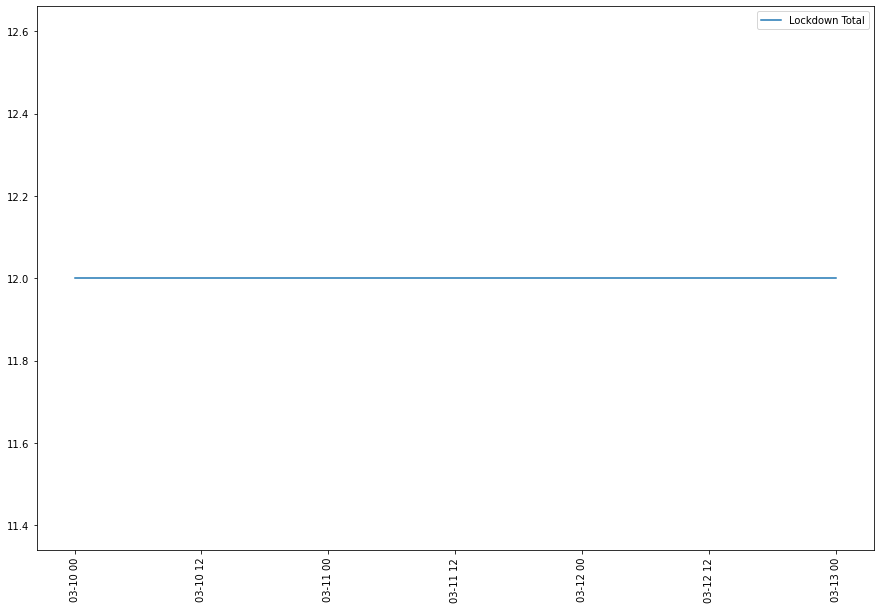

In [29]:
for i, evento in enumerate(lockdown_df.itertuples()):
    plt.xticks(rotation = 90)
    plt.plot((evento[1], evento[2]), (12-i,12-i), label = evento[0])
    plt.legend(loc='upper right')
    plt.savefig('/figs/' + 'lockdown.png')

Faz sentido restringir os períodos a um número menor:
* Período de maior restrição até março/2021
* Período de menor restrição até março/2022

Os demais períodos serão considerados sem restrição

As restrições em escolas públicas não serão avaliadas visto que, aparentemente, não são relevantes para a atividade BM.

O lockdown total não será avaliado por ter duração muito pequena.



#### Períodos de Restrição

Será usado como referência de maior restrição o lockdown de bares e restaurantes

Será usado como referência de menor restrição o lockdown de eventos em local fechado



# Análise Geral

In [ ]:
ocorrencias_df = carrega_dados_ocorrencias()
lockdown_df = ld_agg()
ocorrencias_df = prepara_ocorrencias(ocorrencias_df)

cidades = gera_lista_top_campo(ocorrencias_df, 'CIDADE')
naturezas = gera_lista_top_campo(ocorrencias_df, 'NATUREZA')
restricoes = list(lockdown_df.index)



In [ ]:
%%capture global_pic

df_lim =ocorrencias_df
df_lim_agg = df_lim.groupby('DATA').sum()['QTE']

for restricao in restricoes:
    df_lim_agg_restrito = filtra_periodo(df_lim_agg, lockdown_df, restricao)
    compara_dist(df_lim_agg, df_lim_agg_restrito, 0.05, 0, restricao = restricao)

# Análise por cidade

In [ ]:
%%capture cidades_pic
for cidade in cidades:
    df_lim = filtra_cidade(ocorrencias_df, cidade)
    df_lim_agg = df_lim.groupby('DATA').sum()['QTE']

    for restricao in restricoes:
        df_lim_agg_restrito = filtra_periodo(df_lim_agg, lockdown_df, restricao)
        compara_dist(df_lim_agg, df_lim_agg_restrito, 0.05, 0, cidade, restricao)
   

# Análise por Natureza

In [30]:
%%capture naturezas_pic
        
for natureza in naturezas:
    df_lim = filtra_natureza(ocorrencias_df, natureza)
    df_lim_agg = df_lim.groupby('DATA').sum()['QTE']

    for restricao in restricoes:
        df_lim_agg_restrito = filtra_periodo(df_lim_agg, lockdown_df, restricao)
        compara_dist(df_lim_agg, df_lim_agg_restrito, 0.05, 0, natureza, restricao)

NameError: ignored

In [31]:
help(lockdown_pic)

NameError: ignored

In [32]:
lockdown_pic()

NameError: ignored

In [ ]:
testenormal_pic()

In [ ]:
global_pic()

In [ ]:
cidades_pic()

In [33]:
naturezas_pic()

In [34]:
 !zip -r graph.zip /content/ 



  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2022.09.22/ (stored 0%)
  adding: content/.config/logs/2022.09.22/13.40.36.582025.log (deflated 92%)
  adding: content/.config/logs/2022.09.22/13.41.55.898378.log (deflated 55%)
  adding: content/.config/logs/2022.09.22/13.41.33.220849.log (deflated 54%)
  adding: content/.config/logs/2022.09.22/13.41.24.425810.log (deflated 86%)
  adding: content/.config/logs/2022.09.22/13.41.02.490980.log (deflated 54%)
  adding: content/.config/logs/2022.09.22/13.41.56.678942.log (deflated 53%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)
  adding: content/.config/.last_opt_in_prompt.yaml (stored 0%)
  adding: content/.confi

In [35]:
/content/Distribuição de Ocorrências em ACIDENTE COM VEICULO - GERAL - ACIDENTE TERRESTRE NAO IDENTIFICADO.png

SyntaxError: ignored